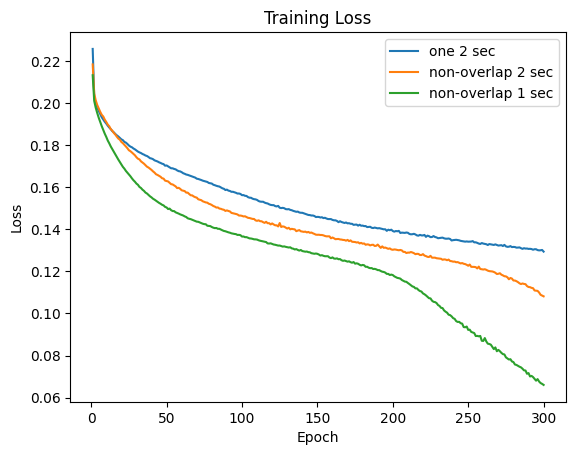

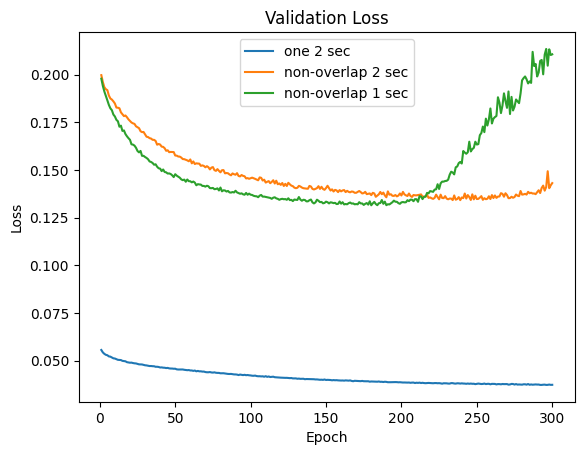

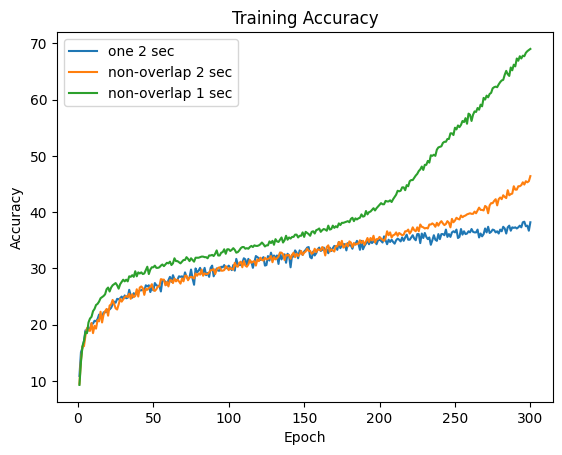

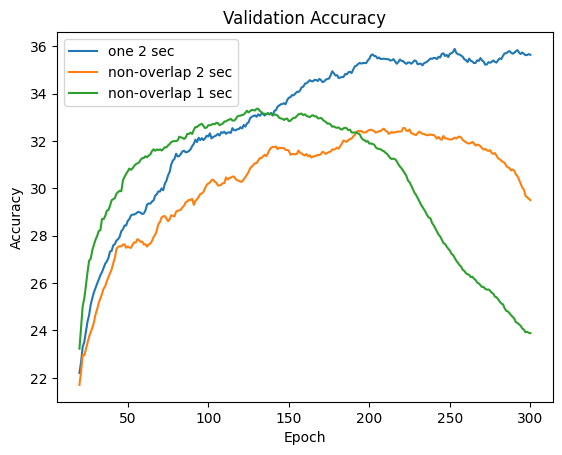

In [1]:
# Plot results

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


filenames = ['saveResults/results_epochs=5000_eps=8_batch_size=64_lr=1e-4.txt','saveResults/results_epochs=4997_seconds_of_history_used=2.0_non_overlapping_sequences_per_instance.txt','saveResults/results_epochs=4997_seconds_of_history_used=1.0_non_overlapping_sequences_per_instance.txt']
num_files = len(filenames)
num_epochs = 300
lenOfOnePerSeq = 2186

# Create empty arrays to store the data
epochs = np.zeros((num_files, num_epochs))
train_loss = np.zeros((num_files, num_epochs))
val_loss = np.zeros((num_files, num_epochs))
train_acc = np.zeros((num_files, num_epochs))
val_acc = np.zeros((num_files, num_epochs))


# Loop over the text files
for i, filename in enumerate(filenames):
    with open(filename, 'r') as f:
        for j, line in enumerate(f):
            if j == num_epochs:
                break
            if line.startswith('Epoch'):
                parts = line.split(': ')
                epoch = int(parts[0].split('[')[1].split('/')[0])
                epochs[i][j] = epoch
                train_loss[i][j] = float(parts[2].split(' |')[0])
                val_loss[i][j] = float(parts[3].split(' |')[0])
                train_acc[i][j] = float(parts[4].split(' %')[0])
                val_acc[i][j] = float(parts[5].split(' %')[0])
            if i == 0:
                train_loss[i][j] = train_loss[i][j]/lenOfOnePerSeq
                val_loss[i][j] = val_loss[i][j]/lenOfOnePerSeq
                

# Plot the data
plt.figure()
# plt.subplot(1, 2, 1)
for i in range(num_files):
    plt.plot(epochs[i], train_loss[i], label=f'File {i+1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['one 2 sec', 'non-overlap 2 sec', 'non-overlap 1 sec'])
plt.show()

# plt.subplot(1, 2, 2)
for i in range(num_files):
    plt.plot(epochs[i], val_loss[i], label=f'File {i+1}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['one 2 sec', 'non-overlap 2 sec', 'non-overlap 1 sec'])
plt.show()

plt.figure()
# plt.subplot(1, 2, 1)
for i in range(num_files):
    plt.plot(epochs[i], train_acc[i], label=f'File {i+1}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['one 2 sec', 'non-overlap 2 sec', 'non-overlap 1 sec'])
plt.show()


# print(f"val_acc={val_acc[0]}")
# print(f"df={df}")
# print(f"smoothed={smoothed}")
# print(f"smoothed_list={smoothed_list}")
# print(f"numpy_smoothed_list.shape={numpy_smoothed_list.shape}")
# print(f"squeezed_numpy_smoothed_list.shape={squeezed_numpy_smoothed_list.shape}")
# print(f"epochs[0].shape={epochs[0].shape}")


# plt.subplot(1, 2, 2)
for i in range(num_files):
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(val_acc[i])
    # Apply a rolling window of size 20 and take the mean of each window
    smoothed = df.rolling(20).mean()
    # Convert the smoothed DataFrame back to a list
    smoothed_list = smoothed.values.tolist()
    numpy_smoothed_list = np.array(smoothed_list)
    squeezed_numpy_smoothed_list = np.squeeze(numpy_smoothed_list, 1)

    plt.plot(epochs[i], squeezed_numpy_smoothed_list, label=f'File {i+1}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['one 2 sec', 'non-overlap 2 sec', 'non-overlap 1 sec'])
plt.show()




In [2]:
# Use pre-saved weights
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from utilsHannes import CoverNetNoRelu
import torch
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import copy

# Load data
version = "v1.0-mini" # v1.0-mini, v1.0-trainval
if version == "v1.0-mini":
    train_subset = "mini_train"
    val_subset = "mini_val"
elif version == "v1.0-trainval":
    train_subset = "train"
    val_subset = "val"
     
DATAROOT = "data/sets/nuscenes"
seconds_of_history_used = 2.0 # Half second steps

sequences_per_instance = "one_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "non_overlapping_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "all_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")


# Model
backbone = ResNetBackbone('resnet50')
covernet = CoverNetNoRelu(backbone, num_modes=64)


/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
num_epochs = 2 
seconds_of_history_used = 2.0
sequences_per_instance = "one_sequences_per_instance"
file_path = f"tmpResults/results_epochs={num_epochs}_seconds_of_history_used={seconds_of_history_used}_{sequences_per_instance}"

# Load weights
covernet = copy.copy(covernet)
covernet.load_state_dict(torch.load(f'{file_path}_weights.pth'))


<All keys matched successfully>

Shape of set of all trajectories = (64, 12, 2)


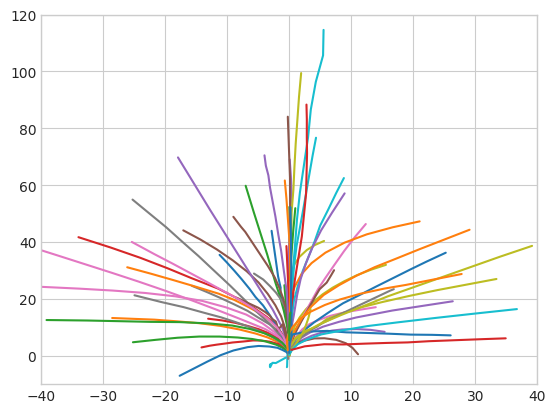

outputyValues = [0.01865152 0.01780739 0.00600963 0.02308176 0.02455527 0.0097686
 0.00652232 0.01604791 0.02071148 0.02081203 0.01673504 0.01250292
 0.01194587 0.00858921 0.01251651 0.01269549 0.02833923 0.02064473
 0.01793653 0.00984872 0.0083739  0.02649801 0.02024584 0.01111768
 0.00899284 0.01427338 0.01949658 0.01419335 0.0203595  0.01685449
 0.00624686 0.01317061 0.01040666 0.01422723 0.01352509 0.01836849
 0.01397112 0.02486455 0.01814617 0.0173337  0.0174717  0.01744097
 0.01204661 0.01042955 0.01929897 0.01160475 0.01351787 0.01124731
 0.01135725 0.00951998 0.01098268 0.01686199 0.0121884  0.01085045
 0.01022325 0.02129138 0.02078104 0.02016254 0.02195859 0.02198059
 0.01575645 0.02095843 0.01051622 0.02516478]
topProbabilitiesIndices = [16 21 63 37  4]


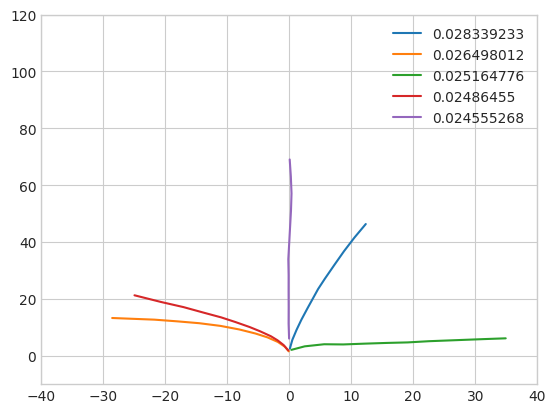

In [5]:
test_index =29

# Load trajectories
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)

### All trajectories
allTrajectories = np.array(trajectories)
print(f"Shape of set of all trajectories = {allTrajectories.shape}")

# Plot all trajectories
modes = np.arange(allTrajectories.shape[0])
timesteps = np.arange(12) # 12 timesteps (which is maximum), can be reduced
for mode in modes:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
plt.show()


### Get probabilities
logits = covernet(img_tensor_list1[test_index], agent_state_vector_list1[test_index])
softmaxy = torch.nn.Softmax(dim=1)
outputy = softmaxy(logits)
outputyValues = outputy.detach().numpy().squeeze()
# print(f"logits = {logits}")
# print(f"outputy.detach() = {outputy.detach()}")
# print(f"torch.sum(outputy).item() = {torch.sum(outputy).item()}")
print(f"outputyValues = {outputyValues}")


### Top trajectories
nrOfTopTrajectories = 5

topProbabilitiesIndices = np.argsort(outputyValues)[::-1][0:nrOfTopTrajectories]
print(f"topProbabilitiesIndices = {topProbabilitiesIndices}")
topProbabilities = []
[topProbabilities.append(outputyValues[index]) for index in topProbabilitiesIndices]


for mode in topProbabilitiesIndices:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
plt.legend(topProbabilities)
plt.show()


In [169]:
import numpy as np
from typing import List, Dict, Any, Tuple

# Load trajectories
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)
lattice = np.array(trajectories)

# Load the .npy files
logits_loaded = np.load(f'{file_path}_logits.npy')
ground_truth_loaded = np.load(f'{file_path}_ground_truth_trajectory.npy')

test_ind = 3
# Print the data
print(f"logits_loaded = {logits_loaded.shape}")
print(f"ground_truth_loaded = {ground_truth_loaded.shape}")
# print(f"logits_loaded[{test_index}] = {logits_loaded[test_ind]}")
# print(f"ground_truth_loaded[{test_index}] = {ground_truth_loaded[test_ind]}")
# print(f"logits_loaded = {logits_loaded}")
# print(f"ground_truth_loaded = {ground_truth_loaded}")


def get_k_most_likely_trajectories(logits: np.ndarray, lattice: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(torch.Tensor(logits))
    sortedProbabilitiesIndices = np.flip(np.array(np.argsort(probabilities, axis=-1))).copy()
    sortedProbabilities = np.array(np.take_along_axis(probabilities, sortedProbabilitiesIndices, axis=-1))
    sortedTrajectories = lattice[sortedProbabilitiesIndices]
    print(f"sortedProbabilities = {sortedProbabilities.shape}")
    print(f"sortedTrajectories = {sortedTrajectories.shape}")
    
    return [sortedProbabilities, sortedTrajectories]
    
[sorted_predicted_probabilities, sorted_predicted_trajectories] = get_k_most_likely_trajectories(logits_loaded, lattice)


def get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_trajectories, k_nr_of_trajectories) -> Tuple[np.array, np.array]:
    
    top_k_trajectories = sorted_predicted_trajectories[:,:k_nr_of_trajectories,:,:]
    
    n_epochs = 2 # TODO, automate
    n_datapoints_per_epoch = 2 # TODO, automate
    
    ave_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    min_ADE = np.zeros([n_datapoints_per_epoch, n_epochs])
    count = 0
    # Loop over epochs
    for e in range(n_epochs):
        
        # Loop over datapoints
        for d in range(n_datapoints_per_epoch):
            tmp_ADE = 1e10
            
            # Loop over each trajectory
            for k in range(k_nr_of_trajectories):
                min_ADE[d,e] = tmp_ADE
                tmp_ADE = np.mean(np.linalg.norm(top_k_trajectories[count,k,:,:] - ground_truth_trajectories[count,:,:], axis=-1))
                print(f"tmp_ADE = {tmp_ADE}")
                ave_ADE[d,e] += tmp_ADE/k_nr_of_trajectories
                if tmp_ADE < min_ADE[d,e]:
                    min_ADE[d,e] = tmp_ADE
            count += 1
            
    return [np.mean(min_ADE, axis=0), np.mean(ave_ADE, axis=0)]

k_nr_of_trajectories = 2
[min_ADE, ave_ADE] = get_ADE_for_k_trajectories(sorted_predicted_trajectories, ground_truth_loaded, k_nr_of_trajectories)
print(f"min_ADE = {min_ADE}")
print(f"ave_ADE = {ave_ADE}")
                              
                              

logits_loaded = (4, 64)
ground_truth_loaded = (4, 12, 2)
sortedProbabilities = (4, 64)
sortedTrajectories = (4, 64, 12, 2)
tmp_ADE = 30.326519088043298
tmp_ADE = 30.401407543267727
tmp_ADE = 29.099947154248657
tmp_ADE = 29.020939192869747
tmp_ADE = 17.707862084673703
tmp_ADE = 29.020939192869747
tmp_ADE = 18.9907529154005
tmp_ADE = 30.401407543267727
min_ADE = [29.67372914 18.3493075 ]
ave_ADE = [29.71220324 24.03024043]
